In [ ]:
''' A music motif generator based on a given song, by Kin Tse '''

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.models import model_from_json

import numpy as np
import matplotlib.pyplot as plt
import datetime

from music21 import *
from itertools import groupby

import copy, os, pdb
from collections import OrderedDict

Using TensorFlow backend.


# Helper Function

In [7]:
def find_lowest_highest_difference_from_track(x):
    a_list = []
    for i in x:
        if i.isNote:
            a_list.append(getMidiNumber(i))
    return min(a_list), max(a_list), max(a_list) - min(a_list) + 1

def getMidiNumber(x):
    if x.isNote:
        midi_num = x.pitch.midi
    else:
        midi_num = 0
    return midi_num

## Output the file
def export_midi(input_data, output_fn='output'):
    now = datetime.datetime.now()
    output_fn = 'midi_output/' + output_fn + '_' + str(now.hour) + '.' + str(now.minute) + '.' + str(now.second) + '.midi'
    mf = midi.translate.streamToMidiFile(input_data)
    mf.open(output_fn, 'wb')
    mf.write()
    mf.close()
    

# Preprocessing

In [8]:
# import Hey Judy Full Score
hey_jude_full_score = converter.parse('midi_samples/beatles/HEYJUDE.MID')

# take the melody track
melody_track = hey_jude_full_score.parts[1]

# get the key off of the score
melody_key = melody_track.pop(0)

# get the notes only  [pre-version note: used to have 'rest' ] .notesAndRests
melody_track = melody_track.notesAndRests

## Preview: we can preview the extracted melody track as below code
# melody_track.show('midi')

## Change the Key from F to C
# Use .transpose(interval.Interval(-5)) to transpose from F to C
melody_track_in_C = melody_track.transpose(interval.Interval(-5))

## Get the Chord track
chord_track = hey_jude_full_score.parts[12]


## Decide the Chord, from a group of notes, example: input : ["C4", "E4", "G4", "A4"]
def get_chord_from_notes(notes_list):  # return key and major/minor
    a_scale = scale.ConcreteScale(pitches = notes_list)
    return a_scale.chord.root().name, a_scale.chord.quality

## Checking, to see how the song look like
# melody_track.getElementsByOffset(0,236).plot('PlotHorizontalBarPitchSpaceOffset', title='Hey Jude by Beatles')dd

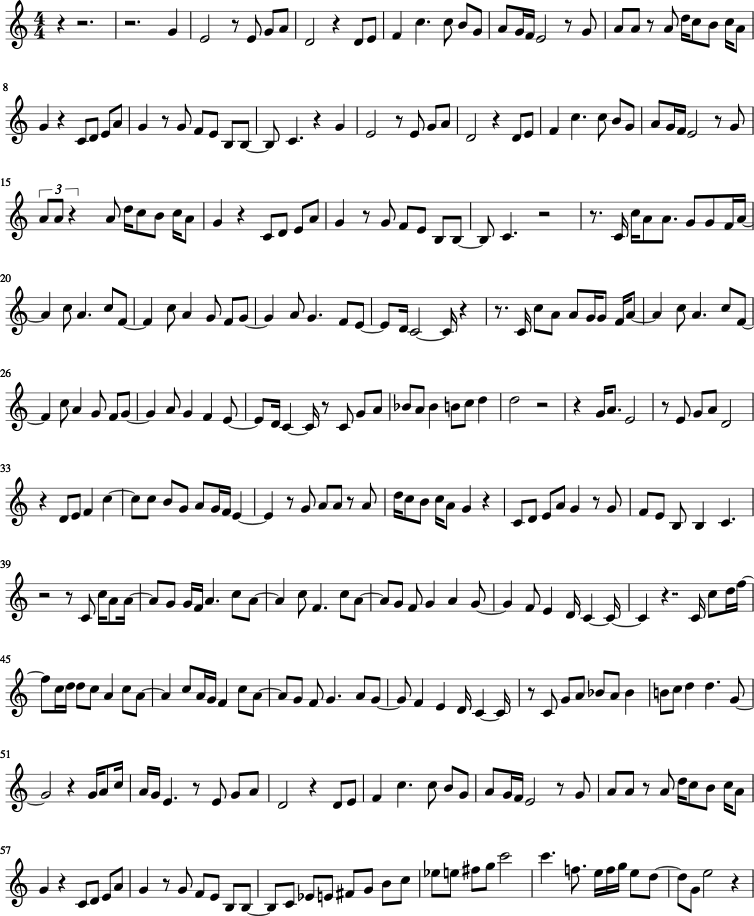

In [4]:
melody_track_in_C.show()

In [9]:
## Pre-processing, strip the song to the meaningful part without the redundent latter part

melody_track_in_C_stripped = melody_track_in_C.getElementsByOffset(0,236)

## Checking

# for i in melody_track_in_C_stripped:
#     if i.isNote:
#         print(i, i.offset, i.pitch)
#     else:
#         print(i, i.offset, 'rest')

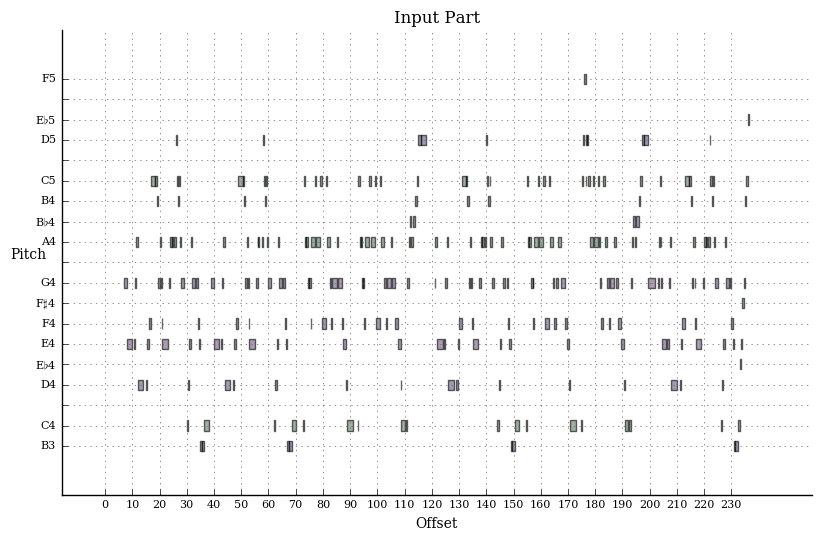

In [6]:
melody_track_in_C_stripped.plot('PlotHorizontalBarPitchSpaceOffset', title='Input Part')

In [10]:
## Find the lowest, highest and interval_difference for setting midi_encode_size
lowest, highest, interval_difference = find_lowest_highest_difference_from_track(melody_track_in_C_stripped)

'''
lowest (59)
highest (84)
interval_difference (26)
'''

'\nlowest (59)\nhighest (84)\ninterval_difference (26)\n'

In [11]:
''' ONE-HOT Encoding method '''

max_length_per_seq = 64  # 16 * 4 : timestamps 4 bars
n_categ = 1 + 1 + interval_difference  # 1 for rest , 1 for hold, then add interval_difference

track_len_in_quarter = melody_track_in_C_stripped[-1].offset
track_len_in_sixteen = int(track_len_in_quarter *4) +1

''' Creat the whole track one-hot array first with notes and rests
NOTE: Without taking care of the holding note/repeated note here yet,
      Will handle it in the Input Array part  
'''
# create a numpy array
whole_track_onehot = np.zeros((track_len_in_sixteen, n_categ), dtype=np.bool)

# whole_track_onehot.shape (1691, 28)

for i in melody_track_in_C_stripped:
    if getMidiNumber(i) == 0:
        whole_track_onehot[int(i.offset*4), 0] = 1
    else:
        whole_track_onehot[int(i.offset*4), getMidiNumber(i) - lowest + 2] = 1
        
# whole_track_onehot.shape (989, 28)

## Checking

# for i in whole_track_onehot[0:64]:
#     print(i)

In [12]:
''' Create the input_array X
This handled holding/repeated note here.

'''

''' If I want to create a larger step later, I can make it like
whole_track_onehot[idx_j + (idx_i * step_size)]

'''

input_array = np.zeros((track_len_in_sixteen - max_length_per_seq, max_length_per_seq, n_categ), dtype=np.bool)

HoldingNoteIdx = -1  # as the indicator for letting know if the note before is holding note

for idx_i, i in enumerate(input_array):
    for idx_j, j in enumerate(i):
        if any(whole_track_onehot[idx_j + idx_i]):  ## Seeing any rest or note here
            if HoldingNoteIdx == np.argmax(whole_track_onehot[idx_j + idx_i]):  # (2) if the note plays again, set it as the Repeated Note as Index 1
                input_array[idx_i, idx_j, 1] = 1
            else:
                input_array[idx_i, idx_j] = whole_track_onehot[idx_j + idx_i]
        else:  ## For seeing empty, that is the holding note
            if idx_j == 0: # (3) If the 1st column vector of the sequence is an empty, then take 1st column vector of the last sequence 
                input_array[idx_i, 0] = input_array[idx_i - 1, 0]
            else:    # (1) if not at the beginning, there is no any 1 in the vector j,then that is the holding note as the same as before note.
                if input_array[idx_i, idx_j - 1, 1] == 1:   # (1.a) if b4 note is a repeated note
                    input_array[idx_i, idx_j] = whole_track_onehot[idx_j + idx_i - 1]  # then put exactly the previous note in the whole_track_onehot into this column vector
                else:  # (1.b) if b4 note is a normal note
                    input_array[idx_i, idx_j] = input_array[idx_i, idx_j - 1]  # then copy the b4 vector column directly
                HoldingNoteIdx = np.argmax(input_array[idx_i, idx_j])

# input_array.shape (925, 64, 28)

## Checking
# for i in input_array[80]:
#     print(i)

[False False False False False False False False False False False False
  True False False False False False False False False]
[False False False False False False False False False False False False
  True False False False False False False False False]
[False False False False False False False False False False  True False
 False False False False False False False False False]
[False False False False False False False False  True False False False
 False False False False False False False False False]
[False False False False False False False  True False False False False
 False False False False False False False False False]
[False False False False False False False  True False False False False
 False False False False False False False False False]
[False False False False False False False  True False False False False
 False False False False False False False False False]
[False False False False False False False  True False False False False
 False False False False

In [13]:
''' Create the target_array Y'''
target_array = np.zeros((track_len_in_sixteen - max_length_per_seq, n_categ), dtype=np.bool)

# target_array.shape (925, 28)

for idx_i, i in enumerate(target_array):
    if idx_i < len(target_array) -1:
        target_array[idx_i] = input_array[idx_i + 1][-1]
    else:
        target_array[idx_i] = target_array[idx_i - 1] # Arbitrary only, have no meaning for this one >_<
    

'''
input_array[i][j][k]
i: sentence index 
j: offset/timestamp in the sentence (64)
k: one-hot encoding

target_array[i][k]
i: sentence index
k: one-hot encoding
'''

## Checking target_array
# target_array[-2]

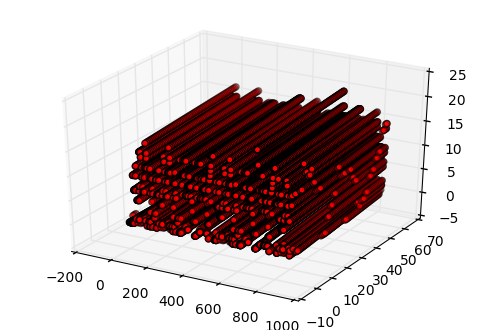

In [11]:
''' Visualize the one-hot matrix '''
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pos = np.where(input_array==1)
ax.scatter(pos[0], pos[1], pos[2], c='red')
plt.show()

In [16]:
## Checking:
'''
X[0][0]
array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
'''
print('input size is {}, Matrix is {}'.format(input_array.size, input_array.shape))

input size is 1184064, Matrix is (881, 64, 21)


# Create a LSTM Model

In [17]:
''' Create the Model '''

model = Sequential()
model.add(LSTM(500, return_sequences=True, input_shape=(max_length_per_seq, n_categ)))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500, return_sequences=False))
model.add(Dense(n_categ))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [ ]:
''' Train the model with model info '''
N_epochs = 300

model.summary()
history = model.fit(input_array, target_array, batch_size=10, nb_epoch=N_epochs)

##--------- summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model and Weight

In [20]:
''' Save Model and save weights '''

# serialize model to JSON
model_json = model.to_json()
with open("model_500x5_e300.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model_500x5_e300.h5")
print("Saved model to disk")

Saved model to disk


# (Optional) Load the saved model and weights

In [100]:
''' Load the saved model and weights'''

# load json and create model
json_file = open('model_500x5_300e.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_500x5_300e.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Loaded model from disk


In [ ]:
''' Train on the Loaded Model with model info '''

N_epochs = 50

loaded_model.summary()
history_w_loaded_model = loaded_model.fit(input_array, target_array, batch_size=10, nb_epoch=N_epochs)

##--------- summarize history for loss
plt.plot(history_w_loaded_model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
## Evaluation for reference

score = loaded_model.evaluate(input_array, target_array, verbose=0)
print(score)

0.0309173036961


In [14]:
''' Generator function'''

def sample_with_randomness(vec):
    e_vec = np.exp(vec)  # log softmax
    s_vec = e_vec / e_vec.sum()  # softmax
    return np.argmax(np.random.multinomial(1, s_vec, 1))


In [129]:
## Makeing Seed randomly (and change it to the down beat) select a sequence of input_array as input to the model as the seed

sample_point = np.random.randint(0, track_len_in_sixteen - max_length_per_seq)
sample_point = sample_point - (sample_point % 4)

input_seed = copy.deepcopy(input_array[sample_point:sample_point+1])
print('Sample Point is %s' % sample_point)

Sample Point is 400


In [124]:
# Softmax sampling (with Temperature), taken from Keras LSTM example
# https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

def sample(preds, temperature=1):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
## Create the empty Generated array first, print out the note's categorical index for checking

gen_array = np.zeros((max_length_per_seq, n_categ), dtype=np.bool)
# gen_array.shape (64, 28)

## Predict, input the predicted note back to the seed, and looping for the new predicts
for i in range(max_length_per_seq):
    predict_output = loaded_model.predict(input_seed)[0]
    gen_note = sample(predict_output)  # Add some randomness here
    gen_array[i,gen_note] = 1
    print(i, gen_note)
    
    for q in range(max_length_per_seq):
        if q < (max_length_per_seq - 1):
            input_seed[0][q] = input_seed[0][q+1]
        else:
            input_seed[0][q] = gen_array[i,gen_note]

In [126]:
''' Decode back to music21 object from the generated array'''

def decoding_from_oneHot(input_oneHot, bpm=60):
    gen_track = stream.Stream()
    current_len = 0
    current_note = -1 # If current_note = 0 means rest
    
    for idx_i, i in enumerate(input_oneHot):
        if np.argmax(i) == 0:  ## When Rest for now
            if current_note == 0:
                current_len += 0.25
            else:
                if idx_i:  # only if it's not the first note in sequence
                    gen_track.append(note.Note(current_note, quarterLength=current_len))
                current_note = 0
                current_len = 0.25
        elif np.argmax(i) == 1:  # When Repeated Note for now
            if current_note == 0:
                gen_track.append(note.Rest(quarterLength=current_len))
                current_len = 0.25
            elif current_note > 0:
                gen_track.append(note.Note(current_note, quarterLength=current_len))
                current_len = 0.25
            elif current_note == -1:  # if the start note is repeat note, make it as the rest first
                current_note = 0
                current_len = 0.25
        else:  # When Musical Note for now
            if current_note == 0:
                gen_track.append(note.Rest(quarterLength=current_len))
                current_note = np.argmax(i) + lowest - 2
                current_len = 0.25
            elif current_note == np.argmax(i) + lowest - 2:  # Seeing Same Note as before
                current_len += 0.25
            else:  # Seeing Another note case
                if idx_i:  # only if it's not the first note in sequence
                    gen_track.append(note.Note(current_note, quarterLength=current_len))
                current_note = np.argmax(i) + lowest - 2
                current_len = 0.25
    gen_track.insert(0.0, tempo.MetronomeMark(number=bpm))
    return gen_track

gen_track = decoding_from_oneHot(gen_array)

In [ ]:
## Show the generated short music

gen_track.show()

In [ ]:
## listen to the generated short music

gen_track.show('midi')

In [116]:
## Export the generated short music

export_midi(gen_track,'500x5params_w_300e_2t')

# Appendix:
### Some codes for reference

In [1]:
from music21 import *

In [11]:
test_s2 = stream.Stream()

r_n = note.Rest(quarterLength=1)
c5 = note.Note('c5', quarterLength=1)
d5 = note.Note('d5', quarterLength=0.5)
d5_2 = note.Note('d5', quarterLength=0.5)
e5 = note.Note('e5', quarterLength=0.75)
e5_2 = note.Note('e5', quarterLength=0.25)


test_s2.append(c5)
test_s2.append(d5)
test_s2.append(d5_2)
test_s2.append(e5)
test_s2.append(e5_2)